# Problem Statement


Any natural language is a medium of communication used by human beings. Natural languages are quite difficult to process using algorithms considering its complexity and variants. Natural Language Processing (NLP) mainly includes three tasks,

- Lexical Processing: Statistical analysis of words present in the given corpora and gain inferences out of it. This can be used for document classification, spam/non-spam classification etc. 

- Syntactic Processing: This includes parsing of sentences and their grammatical structure without considering its meaning. It includes Parts Of Speech (POS) tagging, Information Extraction etc.

- Semantic Processing: This final part includes gaining the meaningful insights out of given corpora. It can be used for higher level application like building program to chat with users to assist them (e.g. customer service).

Here, we are going to focus on POS tagging part of NLP using Viterbi algorithm and regular expression.

POS Tagging: POS (Parts Of Speech) tagging includes tagging English POS (in this case) to each word in the given corpora. The purpose of POS tagging in NLP is to understand correctness of grammatical integrity and extract relationship between each word.

Viterbi Algorithm: It is based on an assumption that POS tag for current words depends upon POS tag for previous word and current word itself (Hidden Markov Model - HMM). It does steps by step maximization of ***P(word_n|POS_n) * P(POS_n|POS_n-1)***. 

For more insights on Viterbi algorithm please check this link:
https://www.freecodecamp.org/news/a-deep-dive-into-part-of-speech-tagging-using-viterbi-algorithm-17c8de32e8bc/

### Dependancies

In [1]:
# Importing libraries

import nltk
nltk.download('treebank')
from nltk.probability import FreqDist

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time
import random
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/kishanakbari/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


## 1. Reading Dataset

NLTK (Natural Language Took-Kit) is having many corpora (datasets). Here, we would be using **treebank corpus** for our algorithm. Here, we would be using universal tag-set as it contains only 12 tags which are easier to parse and computationally less expensive.

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
len(nltk_data)

3914

There are 3914 sentenses in the treebank dataset.

In [4]:
nltk_data[0:10]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

Dataset is in the form of list of sentences where each sentence is a list of tuples. Each tuple contains a word and corresponding POS tag.

Dataset format:
data = [[sent_1], [sent_2], [sent_3],....[sent_n]]

where,
sent_n = [(word_1, POS_1), (word_2, POS_2),....(word_n, POS_n)]

## 2. Train-Test Split

In [5]:
# Splitting into train and test

random.seed(42)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print('Train set size:', len(train_set))

print(' ')

print('Test set size:', len(test_set))

Train set size: 3718
 
Test set size: 196


We would be using only 5% of the data as test set because Viterbi is a computationally expensive algorithm.

## 3. EDA

In [6]:
# train tagged words

train_tagged_words = [x for y in train_set for x in y]
len(train_tagged_words)

95558

Train set is having total 95558 tagged words. It can be repeating as well in line to corpus. Same words can be having different POS tags based on its applicability in the sentence.

In [8]:
# train_words: words in train set

train_words = [x[0] for x in train_tagged_words]
print(train_words[:50])

['The', 'new', 'company', 'will', 'attempt', '*-1', 'to', 'limit', 'the', 'shipyard', "'s", 'losses', ',', 'participants', 'said', '0', '*T*-2', '.', 'This', 'species', 'of', 'congressional', 'action', 'is', 'predicated', '*-50', 'on', 'an', 'interpretation', 'of', 'the', 'appropriations', 'clause', 'that', '*T*-1', 'is', 'erroneous', 'and', 'unconstitutional', '.', 'DOONESBURY', "CREATOR'S", 'UNION', 'TROUBLES', 'are', 'no', 'laughing', 'matter', '.', 'Everyone']


In [9]:
# train set vocabulary

train_vocab = set(train_words)
print(len(train_vocab))

12076


Total vocabulary size for train set is 12076.

In [10]:
# tags from train set
tags = set([x[1] for x in train_tagged_words])

print(tags)

print(' ')

print(len(tags))

{'ADP', 'NUM', 'ADV', 'PRON', '.', 'PRT', 'X', 'ADJ', 'VERB', 'CONJ', 'NOUN', 'DET'}
 
12


Total 12 unique POS tags as per universal tagger standards.

### Developing Tagger as per Viterbi Algorithm

Bayes Theorem:

**P(POS|word) = P(word|POS)P(POS)/P(word)**

Emission Probability = P(word|POS)

Transition Probability = P(POS_n|POS_n-1) 

Where, 

`P(POS|word)` is conditional probability of the tag for a given word,

`p(word|POS)` is the emission probability or conditional probability of the word for given tag,

`p(POS_n|POS_n-1)` is the transition probability or conditional probability of the POS tag for the given previous POS tag.

In [11]:
# Emission Probability
# Here, 'tag' stands for POS tag

def emission(word, tag, train = train_tagged_words):
    tag_list = [x for x in train if x[1]==tag]
    w_given_tag_list = [x[0] for x in tag_list if x[0]==word]
    count_tag = len(tag_list)
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag/count_tag)

In [12]:
# Transition Probability

def transition(t2, t1, train = train_tagged_words):
    tags = [x[1] for x in train]
    count_t1 = len([x for x in tags if x==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1/count_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = transition(t2, t1)

In [14]:
# convert the matrix to a df for better readability

tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,ADP,NUM,ADV,PRON,.,PRT,X,ADJ,VERB,CONJ,NOUN,DET
ADP,0.016924,0.063196,0.013068,0.068445,0.040274,0.001285,0.034597,0.106255,0.008355,0.000857,0.322194,0.324550
NUM,0.034155,0.186813,0.002970,0.001485,0.117612,0.027621,0.213246,0.033561,0.018117,0.012474,0.348381,0.003564
ADV,0.118058,0.031260,0.078484,0.015298,0.136016,0.013302,0.023612,0.130695,0.346192,0.006984,0.031593,0.068507
PRON,0.022437,0.007350,0.034429,0.007737,0.042166,0.011992,0.092456,0.071567,0.486267,0.005416,0.208511,0.009671
.,0.090860,0.081173,0.052740,0.064849,0.092833,0.002332,0.026908,0.044578,0.088618,0.058391,0.222172,0.174455
PRT,0.020235,0.056789,0.010444,0.016645,0.043407,0.001958,0.013055,0.085836,0.400783,0.002285,0.246084,0.102480
X,0.144243,0.002863,0.024332,0.056298,0.164917,0.186069,0.074587,0.017017,0.204358,0.010178,0.061546,0.053594
ADJ,0.078431,0.020102,0.004778,0.000659,0.064591,0.011040,0.020596,0.066733,0.011864,0.016312,0.699951,0.004943
VERB,0.091128,0.022335,0.082101,0.035564,0.035331,0.031595,0.218210,0.065837,0.167938,0.005214,0.109961,0.134786
CONJ,0.054130,0.041064,0.055530,0.059729,0.035464,0.004666,0.008866,0.116659,0.152590,0.000467,0.350910,0.119925


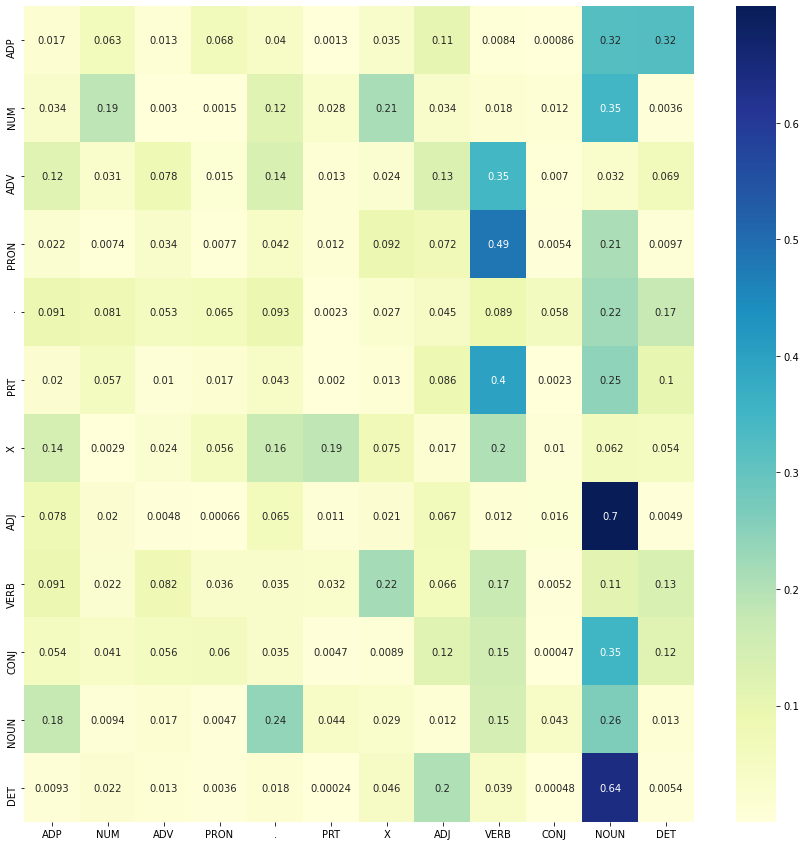

In [15]:
# transition map

plt.figure(figsize=(15, 15))
sns.heatmap(tags_df, cmap='YlGnBu', annot=True)
plt.show()

Observation,
- DET followed by NOUN is having probability of 0.64.
- ADJ followed by NOUN is having probability of 0.7.
- PRON followed by VERB is having probability of 0.49.

In [23]:
# Developing Viterbi algorithm funcation: Returns words and corresponding predicted POS tag


def Viter1(words, train_bag = train_tagged_words):
    count1 = 0
    state = []
    
    for key, word in enumerate(words):
        p = [] 
        for tag in tags:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            emission_p = emission(word, tag)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
                       
        pmax = max(p)
        T = list(tags)
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        print(count1, word, state_max)
        count1 += 1
    return list(zip(words, state))

In [26]:
start = time.time()
test_pred = Viter1([x[0] for y in test_set for x in y])
end = time.time()
difference = end-start
print("Time taken (in seconds): ", difference)

0 In ADP
1 an DET
2 eight-count ADP
3 indictment ADP
4 , .
5 the DET
6 government NOUN
7 has VERB
8 charged VERB
9 GAF NOUN
10 , .
11 a DET
12 Wayne NOUN
13 , .
14 N.J. NOUN
15 , .
16 specialty NOUN
17 chemical NOUN
18 maker NOUN
19 , .
20 and CONJ
21 its PRON
22 Vice ADP
23 Chairman NOUN
24 James NOUN
25 T. NOUN
26 Sherwin ADP
27 with ADP
28 *-2 X
29 attempting VERB
30 *-1 X
31 to PRT
32 manipulate ADP
33 the DET
34 common ADJ
35 stock NOUN
36 of ADP
37 Union NOUN
38 Carbide ADP
39 Corp. NOUN
40 in ADP
41 advance NOUN
42 of ADP
43 GAF NOUN
44 's PRT
45 planned VERB
46 sale NOUN
47 of ADP
48 a DET
49 large ADJ
50 block NOUN
51 of ADP
52 the DET
53 stock NOUN
54 in ADP
55 November NOUN
56 1986 NUM
57 . .
58 When ADV
59 Ms. NOUN
60 Evans NOUN
61 took VERB
62 her PRON
63 job NOUN
64 *T*-1 X
65 , .
66 several ADJ
67 important ADJ
68 divisions NOUN
69 that ADP
70 *T*-2 X
71 had VERB
72 reported VERB
73 to PRT
74 her PRON
75 predecessor NOUN
76 were VERB
77 n't ADV
78 included VERB
79 *-3 X


617 C.D.s ADP
618 , .
619 usually ADV
620 on ADP
621 amounts NOUN
622 of ADP
623 $ .
624 1 NUM
625 million NUM
626 and CONJ
627 more ADJ
628 *U* X
629 . .
630 Mr. NOUN
631 McGovern NOUN
632 himself PRON
633 had VERB
634 said VERB
635 repeatedly ADP
636 that DET
637 he PRON
638 intended VERB
639 *-1 X
640 to PRT
641 stay VERB
642 on ADP
643 until ADP
644 he PRON
645 reached VERB
646 the DET
647 conventional ADJ
648 retirement NOUN
649 age NOUN
650 of ADP
651 65 NUM
652 in ADP
653 October NOUN
654 1991 NUM
655 , .
656 `` .
657 unless ADP
658 I PRON
659 get VERB
660 fired VERB
661 . .
662 '' .
663 The DET
664 Latin ADP
665 American ADJ
666 nation NOUN
667 has VERB
668 paid VERB
669 very ADV
670 little ADJ
671 on ADP
672 its PRON
673 debt NOUN
674 since ADP
675 early ADJ
676 last ADJ
677 year NOUN
678 . .
679 Mr. NOUN
680 Klauser NOUN
681 says VERB
682 0 X
683 Mitsui NOUN
684 has VERB
685 75 NUM
686 U.S. NOUN
687 subsidiaries NOUN
688 in ADP
689 which DET
690 it PRON
691 holds VERB
692 35 

1210 nearly ADV
1211 1,500 NUM
1212 alleged ADJ
1213 violations NOUN
1214 of ADP
1215 federal ADJ
1216 electrical ADJ
1217 , .
1218 crane-safety ADP
1219 , .
1220 record-keeping ADJ
1221 and CONJ
1222 other ADJ
1223 requirements NOUN
1224 . .
1225 Video ADP
1226 Tip ADP
1227 : .
1228 Before ADP
1229 *-1 X
1230 seeing VERB
1231 `` .
1232 Sidewalk NOUN
1233 Stories NOUN
1234 , .
1235 '' .
1236 * X
1237 take VERB
1238 a DET
1239 look NOUN
1240 at ADP
1241 `` .
1242 City NOUN
1243 Lights NOUN
1244 , .
1245 '' .
1246 Chaplin NOUN
1247 's PRT
1248 Tramp NOUN
1249 at ADP
1250 his PRON
1251 finest ADP
1252 . .
1253 `` .
1254 Only ADV
1255 five NUM
1256 of ADP
1257 the DET
1258 40 NUM
1259 questions NOUN
1260 were VERB
1261 geography NOUN
1262 questions NOUN
1263 . .
1264 The DET
1265 size NOUN
1266 of ADP
1267 the DET
1268 issue NOUN
1269 was VERB
1270 increased VERB
1271 *-1 X
1272 from ADP
1273 an DET
1274 originally ADV
1275 planned VERB
1276 $ .
1277 500 NUM
1278 million NUM
1279 *U* X
128

1772 torrent ADP
1773 of ADP
1774 replies VERB
1775 that ADP
1776 *T*-1 X
1777 followed VERB
1778 , .
1779 one NUM
1780 woman NOUN
1781 ringer NOUN
1782 from ADP
1783 Solihull ADP
1784 observed VERB
1785 that ADP
1786 `` .
1787 the DET
1788 average ADJ
1789 male NOUN
1790 ringer NOUN
1791 leaves VERB
1792 quite ADV
1793 a DET
1794 lot NOUN
1795 0 X
1796 *T*-2 X
1797 to PRT
1798 be VERB
1799 desired ADP
1800 *-141 ADP
1801 : .
1802 *-3 X
1803 badly ADV
1804 dressed ADP
1805 , .
1806 decorated ADP
1807 with ADP
1808 acne NOUN
1809 and CONJ
1810 a DET
1811 large ADJ
1812 beer-belly ADP
1813 , .
1814 frequently ADV
1815 unwashed ADP
1816 and CONJ
1817 unbearably ADP
1818 flatulent ADP
1819 in ADP
1820 peals NOUN
1821 . .
1822 '' .
1823 Britain NOUN
1824 has VERB
1825 two NUM
1826 main ADJ
1827 index-arbitrage ADJ
1828 instruments NOUN
1829 . .
1830 I PRON
1831 would VERB
1832 be VERB
1833 very ADV
1834 surprised VERB
1835 if ADP
1836 his PRON
1837 departure NOUN
1838 signals VERB
1839 any 

2339 advertisers NOUN
2340 and CONJ
2341 raised VERB
2342 the DET
2343 ire ADP
2344 of ADP
2345 others NOUN
2346 . .
2347 `` .
2348 If ADP
2349 I PRON
2350 were VERB
2351 choosing VERB
2352 the DET
2353 people NOUN
2354 of ADP
2355 tomorrow NOUN
2356 , .
2357 I PRON
2358 would VERB
2359 have VERB
2360 chosen VERB
2361 the DET
2362 people NOUN
2363 who PRON
2364 *T*-1 X
2365 are VERB
2366 now ADV
2367 on ADP
2368 the DET
2369 board NOUN
2370 , .
2371 '' .
2372 he PRON
2373 said VERB
2374 *T*-2 X
2375 . .
2376 As ADP
2377 for ADP
2378 the DET
2379 findings NOUN
2380 on ADP
2381 the DET
2382 203 NUM
2383 Baltimore NOUN
2384 homeless NOUN
2385 who PRON
2386 *T*-18 X
2387 underwent VERB
2388 psychiatric ADJ
2389 examinations ADP
2390 , .
2391 I PRON
2392 suggest VERB
2393 0 X
2394 you PRON
2395 conduct VERB
2396 your PRON
2397 own ADJ
2398 survey NOUN
2399 . .
2400 Mr. NOUN
2401 Trudeau NOUN
2402 's PRT
2403 attorney NOUN
2404 , .
2405 Norman NOUN
2406 K. NOUN
2407 Samnick NOUN
2408 , .
240

2909 its PRON
2910 1989 NUM
2911 earnings NOUN
2912 by ADP
2913 $ .
2914 1.55 NUM
2915 *U* X
2916 a DET
2917 share NOUN
2918 . .
2919 The DET
2920 May NOUN
2921 contract NOUN
2922 , .
2923 which DET
2924 *T*-1 X
2925 also ADV
2926 is VERB
2927 without ADP
2928 restraints ADP
2929 , .
2930 ended VERB
2931 with ADP
2932 a DET
2933 gain NOUN
2934 of ADP
2935 0.54 ADP
2936 cent NOUN
2937 to PRT
2938 14.26 ADP
2939 cents NOUN
2940 . .
2941 Instead ADV
2942 , .
2943 the DET
2944 companies NOUN
2945 will VERB
2946 leave VERB
2947 it PRON
2948 up ADV
2949 to PRT
2950 the DET
2951 marketplace NOUN
2952 * X
2953 to PRT
2954 decide VERB
2955 . .
2956 `` .
2957 Wa .
2958 '' .
2959 is VERB
2960 Japanese ADJ
2961 for ADP
2962 `` .
2963 team NOUN
2964 spirit NOUN
2965 '' .
2966 and CONJ
2967 Japanese ADJ
2968 ballplayers NOUN
2969 have VERB
2970 miles NOUN
2971 and CONJ
2972 miles NOUN
2973 of ADP
2974 it PRON
2975 . .
2976 USX NOUN
2977 was VERB
2978 cited VERB
2979 *-1 X
2980 by ADP
2981 OSHA NOUN


3467 *T*-2 X
3468 , .
3469 when ADV
3470 narrowly ADP
3471 focused VERB
3472 funds NOUN
3473 grew VERB
3474 wildly ADP
3475 popular ADJ
3476 *T*-1 X
3477 . .
3478 For ADP
3479 the DET
3480 year NOUN
3481 , .
3482 electronics NOUN
3483 emerged ADP
3484 as ADP
3485 Rockwell NOUN
3486 's PRT
3487 largest ADJ
3488 sector NOUN
3489 in ADP
3490 terms NOUN
3491 of ADP
3492 sales NOUN
3493 and CONJ
3494 earnings NOUN
3495 , .
3496 *-1 X
3497 muscling ADP
3498 out ADP
3499 aerospace NOUN
3500 for ADP
3501 the DET
3502 first ADJ
3503 time NOUN
3504 . .
3505 Because ADP
3506 of ADP
3507 the DET
3508 rulings NOUN
3509 , .
3510 the DET
3511 Commerce NOUN
3512 Department NOUN
3513 will VERB
3514 continue VERB
3515 *-1 X
3516 to PRT
3517 investigate ADP
3518 complaints NOUN
3519 *ICH*-2 X
3520 by ADP
3521 U.S. NOUN
3522 sweater ADP
3523 makers NOUN
3524 that ADP
3525 the DET
3526 imports NOUN
3527 are VERB
3528 reaching VERB
3529 the DET
3530 U.S. NOUN
3531 at ADP
3532 unfairly ADV
3533 low ADJ
3534 

4034 customer NOUN
4035 that ADP
4036 banks NOUN
4037 pine ADP
4038 for ADP
4039 *T*-1 X
4040 , .
4041 she PRON
4042 did VERB
4043 n't ADV
4044 give VERB
4045 much ADV
4046 thought VERB
4047 to PRT
4048 the DET
4049 rates NOUN
4050 0 X
4051 she PRON
4052 was VERB
4053 receiving VERB
4054 *T*-2 X
4055 , .
4056 nor CONJ
4057 to PRT
4058 the DET
4059 fees NOUN
4060 0 X
4061 she PRON
4062 was VERB
4063 paying VERB
4064 *T*-3 X
4065 . .
4066 `` .
4067 Who PRON
4068 *T*-1 X
4069 's PRT
4070 really ADV
4071 lying VERB
4072 ? .
4073 '' .
4074 asks VERB
4075 *T*-2 X
4076 a DET
4077 female ADJ
4078 voice NOUN
4079 . .
4080 Net ADJ
4081 income NOUN
4082 more ADV
4083 than ADP
4084 tripled VERB
4085 to PRT
4086 4.898 ADP
4087 billion NUM
4088 yen NOUN
4089 from ADP
4090 1.457 ADP
4091 billion NUM
4092 yen NOUN
4093 a DET
4094 year NOUN
4095 earlier ADV
4096 . .
4097 It PRON
4098 shed ADP
4099 about ADP
4100 7 NUM
4101 pence NOUN
4102 , .
4103 however ADV
4104 , .
4105 after ADP
4106 dealers NOUN
4

4601 's PRT
4602 support VERB
4603 among ADP
4604 the DET
4605 very ADV
4606 women NOUN
4607 who PRON
4608 *T*-77 X
4609 were VERB
4610 attracted VERB
4611 *-1 X
4612 by ADP
4613 the DET
4614 abortion NOUN
4615 ad NOUN
4616 . .
4617 They PRON
4618 expect VERB
4619 him PRON
4620 to PRT
4621 cut VERB
4622 costs NOUN
4623 throughout ADP
4624 the DET
4625 organization NOUN
4626 . .
4627 The DET
4628 IRS NOUN
4629 warnings NOUN
4630 stem VERB
4631 from ADP
4632 a DET
4633 1984 NUM
4634 law NOUN
4635 that ADP
4636 *T*-1 X
4637 requires VERB
4638 anyone NOUN
4639 who PRON
4640 *T*-126 ADP
4641 receives ADP
4642 more ADJ
4643 than ADP
4644 $ .
4645 10,000 NUM
4646 *U* X
4647 in ADP
4648 cash NOUN
4649 from ADP
4650 a DET
4651 client NOUN
4652 or CONJ
4653 customer NOUN
4654 in ADP
4655 one NUM
4656 or CONJ
4657 more ADJ
4658 related ADJ
4659 transactions NOUN
4660 `` .
4661 in ADP
4662 the DET
4663 course NOUN
4664 of ADP
4665 trade NOUN
4666 or CONJ
4667 business NOUN
4668 '' .
4669 to PRT
46

In [27]:
# accuracy check
# wrong_pos --> there are words which are wrongly tagged by our tagger

test_tagged_words = [x for y in test_set for x in y]
wrong_pos = [(i,j,k) for i,j,k in list(zip([x[0] for x in test_tagged_words],
                                  [x[1] for x in test_tagged_words],
                                  [x[1] for x in test_pred])) if j != k]
accuracy1 = 1-len(wrong_pos)/len(test_tagged_words)
accuracy1

0.9038686987104337

We are getting accuracy of ~90% on the test set, which is good. But let's try to improve it further.

#### Checking unknown words

- Words which are not present in train set but are there in test set. These words would be having emission probability of 0.
- We would be using `Regular Expression` based tagger for unknown words instead of using Viterbi method

`Regular Expression` based Tagger: We use a set of rules to define the POS for the given word. Rules can be related to alphabets in word itself. e.g. words ending with 'ing' should be tagged as VERB. 

In [29]:
unknown_words_pos = [x for x in wrong_pos if x[0] not in train_vocab]
unknown_words_pos

[('eight-count', 'ADJ', 'ADP'),
 ('indictment', 'NOUN', 'ADP'),
 ('Vice', 'NOUN', 'ADP'),
 ('Sherwin', 'NOUN', 'ADP'),
 ('manipulate', 'VERB', 'ADP'),
 ('Carbide', 'NOUN', 'ADP'),
 ('daughters', 'NOUN', 'ADP'),
 ('Pierre', 'NOUN', 'ADP'),
 ('accounted', 'VERB', 'ADP'),
 ('sterling', 'NOUN', 'ADP'),
 ('Menem', 'NOUN', 'ADP'),
 ('metropolitan', 'ADJ', 'ADP'),
 ('Rate', 'NOUN', 'ADP'),
 ('Monitor', 'NOUN', 'ADP'),
 ('practicing', 'VERB', 'ADP'),
 ('journalistic', 'ADJ', 'ADP'),
 ('garbage', 'NOUN', 'ADP'),
 ('fumes', 'VERB', 'ADP'),
 ('designing', 'VERB', 'ADP'),
 ('257', 'NUM', 'ADP'),
 ('desired', 'VERB', 'ADP'),
 ('bombarding', 'VERB', 'ADP'),
 ('neutrons', 'NOUN', 'ADP'),
 ('radioactivity', 'NOUN', 'ADP'),
 ('large-scale', 'ADJ', 'ADP'),
 ('facial', 'ADJ', 'ADP'),
 ('Composer', 'NOUN', 'ADP'),
 ('Marc', 'NOUN', 'ADP'),
 ('Marder', 'NOUN', 'ADP'),
 ('double', 'ADJ', 'ADP'),
 ('bass', 'NOUN', 'ADP'),
 ('classical', 'ADJ', 'ADP'),
 ('ensembles', 'NOUN', 'ADP'),
 ('exciting', 'ADJ', 'ADP'

This is a subset of wrongly tagged words which are not present in training set.

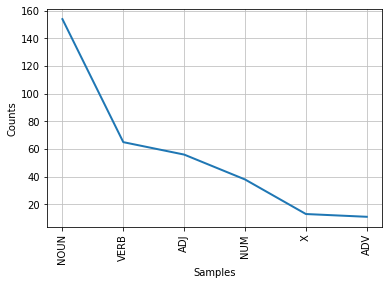

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [30]:
# Checking distribution of unknown words POs tags

FreqDist([x[1] for x in unknown_words_pos]).plot()

Observation,
- Tagger unable to tag `NOUN`, `VERB`, `ADJ`, `NUM`, `X` and `ADV` from unknown group of words. It is assigning all above kind to `ADP` because `ADP` is the first tag in out transition probability matrix. 


Next, lets do analysis of words from unknown group and try to develop a set of rules to tag them correctly.

#### VERB analysis

In [41]:
print([x for x in unknown_words_pos if x[1] =='VERB'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='VERB']))

[('manipulate', 'VERB', 'ADP'), ('accounted', 'VERB', 'ADP'), ('practicing', 'VERB', 'ADP'), ('fumes', 'VERB', 'ADP'), ('designing', 'VERB', 'ADP'), ('desired', 'VERB', 'ADP'), ('bombarding', 'VERB', 'ADP'), ('blurred', 'VERB', 'ADP'), ('double', 'VERB', 'ADP'), ('functioning', 'VERB', 'ADP'), ('curtailed', 'VERB', 'ADP'), ('accrue', 'VERB', 'ADP'), ('apologize', 'VERB', 'ADP'), ('stimulated', 'VERB', 'ADP'), ('saving', 'VERB', 'ADP'), ('demobilize', 'VERB', 'ADP'), ('tailoring', 'VERB', 'ADP'), ('notify', 'VERB', 'ADP'), ('completing', 'VERB', 'ADP'), ('assessed', 'VERB', 'ADP'), ('desired', 'VERB', 'ADP'), ('dressed', 'VERB', 'ADP'), ('decorated', 'VERB', 'ADP'), ('Regarded', 'VERB', 'ADP'), ('ENDED', 'VERB', 'ADP'), ('Encouraging', 'VERB', 'ADP'), ('drooled', 'VERB', 'ADP'), ('fly', 'VERB', 'ADP'), ('fly', 'VERB', 'ADP'), ('alienated', 'VERB', 'ADP'), ('consists', 'VERB', 'ADP'), ('concede', 'VERB', 'ADP'), ('tempts', 'VERB', 'ADP'), ('frustrating', 'VERB', 'ADP'), ('invent', 'VERB'

In [32]:
print([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('ing')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('ing')]))

['practicing', 'designing', 'bombarding', 'functioning', 'saving', 'tailoring', 'completing', 'Encouraging', 'frustrating', 'cooperating', 'muscling', 'Reducing', 'crying', 'heading']
 
14


In [33]:
print([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('ed')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('ed')]))

['accounted', 'desired', 'blurred', 'curtailed', 'stimulated', 'assessed', 'desired', 'dressed', 'decorated', 'Regarded', 'drooled', 'alienated', 'revised', 'conducted', 'ignored', 'emerged', 'shed', 'borrowed', 'fashioned', 'waived', 'relied']
 
21


In [34]:
print([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('es')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('es')]))

['fumes', 'aces', 'mandates', 'receives']
 
4


We can see many words which are ending with 'ing' or 'ed' or 'es' which are actually verbs but tagged as 'ADP'. Hence we would defined rules for that.

In [35]:
patterns_verb = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
]

#### ADV analysis

In [40]:
print([x for x in unknown_words_pos if x[1] =='ADV'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='ADV']))

[('repeatedly', 'ADV', 'ADP'), ('inaccurately', 'ADV', 'ADP'), ('unbearably', 'ADV', 'ADP'), ('sufficiently', 'ADV', 'ADP'), ('enormously', 'ADV', 'ADP'), ('barely', 'ADV', 'ADP'), ('Invariably', 'ADV', 'ADP'), ('noncompetitively', 'ADV', 'ADP'), ('narrowly', 'ADV', 'ADP'), ('wildly', 'ADV', 'ADP'), ('awfully', 'ADV', 'ADP')]
 
11


In [37]:
print([x[0] for x in unknown_words_pos if x[1] =='ADV' and x[0].endswith('ly')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='ADV' and x[0].endswith('ly')]))

['repeatedly', 'inaccurately', 'unbearably', 'sufficiently', 'enormously', 'barely', 'Invariably', 'noncompetitively', 'narrowly', 'wildly', 'awfully']
 
11


We can see many words which are ending with 'ly' which are actually 'ADV' but tagged as 'ADP'. Hence we would defined rule for that.

In [38]:
patterns_adv = [
    (r'.*ly$', 'ADV')
]

#### X Analysis

In [42]:
print([x for x in unknown_words_pos if x[1] =='X'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='X']))

[('*-133', 'X', 'ADP'), ('*-141', 'X', 'ADP'), ('*-113', 'X', 'ADP'), ('*-82', 'X', 'ADP'), ('*T*-180', 'X', 'ADP'), ('*T*-105', 'X', 'ADP'), ('*T*-235', 'X', 'ADP'), ('*T*-178', 'X', 'ADP'), ('*-139', 'X', 'ADP'), ('*-160', 'X', 'ADP'), ('*T*-221', 'X', 'ADP'), ('*T*-126', 'X', 'ADP'), ('*T*-154', 'X', 'ADP')]
 
13


These are the foreign words which should be tagged as 'X' but are predicted as 'ADP'. We can't define as any rule for such words. Hence, we would leave them as it is.

#### NOUN Analysis

In [43]:
print([x for x in unknown_words_pos if x[1] =='NOUN'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='NOUN']))

[('indictment', 'NOUN', 'ADP'), ('Vice', 'NOUN', 'ADP'), ('Sherwin', 'NOUN', 'ADP'), ('Carbide', 'NOUN', 'ADP'), ('daughters', 'NOUN', 'ADP'), ('Pierre', 'NOUN', 'ADP'), ('sterling', 'NOUN', 'ADP'), ('Menem', 'NOUN', 'ADP'), ('Rate', 'NOUN', 'ADP'), ('Monitor', 'NOUN', 'ADP'), ('garbage', 'NOUN', 'ADP'), ('neutrons', 'NOUN', 'ADP'), ('radioactivity', 'NOUN', 'ADP'), ('Composer', 'NOUN', 'ADP'), ('Marc', 'NOUN', 'ADP'), ('Marder', 'NOUN', 'ADP'), ('bass', 'NOUN', 'ADP'), ('ensembles', 'NOUN', 'ADP'), ('characters', 'NOUN', 'ADP'), ('intertitles', 'NOUN', 'ADP'), ('Bradford', 'NOUN', 'ADP'), ('C.D.s', 'NOUN', 'ADP'), ('Latin', 'NOUN', 'ADP'), ('surpluses', 'NOUN', 'ADP'), ('CERTIFICATES', 'NOUN', 'ADP'), ('DEPOSIT', 'NOUN', 'ADP'), ('Paso', 'NOUN', 'ADP'), ('boots', 'NOUN', 'ADP'), ('leather', 'NOUN', 'ADP'), ('envoy', 'NOUN', 'ADP'), ('Teikoku', 'NOUN', 'ADP'), ('Blackstone', 'NOUN', 'ADP'), ('History', 'NOUN', 'ADP'), ('crane-safety', 'NOUN', 'ADP'), ('Video', 'NOUN', 'ADP'), ('Tip', '

In [45]:
print([x[0] for x in unknown_words_pos if x[1] =='NOUN' and x[0].endswith('s')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='NOUN' and x[0].endswith('s')]))

['daughters', 'neutrons', 'bass', 'ensembles', 'characters', 'intertitles', 'C.D.s', 'surpluses', 'boots', 'sub-segments', 'styles', 'Friedrichs', 'Courts', 'pills', 'ministers', 'borrowings', 'schoolboys', 'honors', 'examinations', 'polls', 'daughters', 'Characters', 'Dogs', 'Bugs', 'Landis', 'restraints', 'Articles', 'hits', 'opinions', 'Policies', 'Buyers', 'desires', 'salaries', 'Coors', 'Bumkins']
 
35


We can see many words which are ending with 's' which are actually 'NOUN' but tagged as 'ADP'. Hence we would defined rule for that.

In [46]:
patterns_noun = [
        (r'.*s$', 'NOUN'),              # plural nouns
]

#### ADJ Analysis

In [47]:
print([x for x in unknown_words_pos if x[1] =='ADJ'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='ADJ']))

[('eight-count', 'ADJ', 'ADP'), ('metropolitan', 'ADJ', 'ADP'), ('journalistic', 'ADJ', 'ADP'), ('large-scale', 'ADJ', 'ADP'), ('facial', 'ADJ', 'ADP'), ('double', 'ADJ', 'ADP'), ('classical', 'ADJ', 'ADP'), ('exciting', 'ADJ', 'ADP'), ('eclectic', 'ADJ', 'ADP'), ('negotiable', 'ADJ', 'ADP'), ('land-idling', 'ADJ', 'ADP'), ('price-depressing', 'ADJ', 'ADP'), ('labor-backed', 'ADJ', 'ADP'), ('unofficial', 'ADJ', 'ADP'), ('packed', 'ADJ', 'ADP'), ('pre-approved', 'ADJ', 'ADP'), ('finest', 'ADJ', 'ADP'), ('genuine', 'ADJ', 'ADP'), ('touchy', 'ADJ', 'ADP'), ('one-house', 'ADJ', 'ADP'), ('bicameral', 'ADJ', 'ADP'), ('unwashed', 'ADJ', 'ADP'), ('flatulent', 'ADJ', 'ADP'), ('whimsical', 'ADJ', 'ADP'), ('enviable', 'ADJ', 'ADP'), ('inauspicious', 'ADJ', 'ADP'), ('generous', 'ADJ', 'ADP'), ('low-tech', 'ADJ', 'ADP'), ('strategic', 'ADJ', 'ADP'), ('proof', 'ADJ', 'ADP'), ('high-volume', 'ADJ', 'ADP'), ('awful', 'ADJ', 'ADP'), ('would-be', 'ADJ', 'ADP'), ('year-long', 'ADJ', 'ADP'), ('red-carpet'

In [48]:
print([x[0] for x in unknown_words_pos if x[1] =='ADJ' and x[0].endswith('est')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='ADJ' and x[0].endswith('est')]))

['finest']
 
1


There are a few words ending with 'est' should be considered as 'ADJ'. These words are very less in count. Hence, we would not try to assign any rule. This is to avoid any sort of over-fitting and try to define as generic rules as possible.

#### NUM Analysis

In [49]:
print([x for x in unknown_words_pos if x[1] =='NUM'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='NUM']))

[('257', 'NUM', 'ADP'), ('1.9', 'NUM', 'ADP'), ('8.06', 'NUM', 'ADP'), ('78', 'NUM', 'ADP'), ('47.1', 'NUM', 'ADP'), ('1,460', 'NUM', 'ADP'), ('150,000', 'NUM', 'ADP'), ('1995', 'NUM', 'ADP'), ('9\\/32', 'NUM', 'ADP'), ('103', 'NUM', 'ADP'), ('11.10', 'NUM', 'ADP'), ('1787', 'NUM', 'ADP'), ('2,099', 'NUM', 'ADP'), ('721', 'NUM', 'ADP'), ('2.62', 'NUM', 'ADP'), ('598', 'NUM', 'ADP'), ('2.07', 'NUM', 'ADP'), ('143.93', 'NUM', 'ADP'), ('143.08', 'NUM', 'ADP'), ('8.64', 'NUM', 'ADP'), ('1986-87', 'NUM', 'ADP'), ('1987-88', 'NUM', 'ADP'), ('116.4', 'NUM', 'ADP'), ('116.3', 'NUM', 'ADP'), ('1991-1999', 'NUM', 'ADP'), ('87.5', 'NUM', 'ADP'), ('38.875', 'NUM', 'ADP'), ('0.54', 'NUM', 'ADP'), ('14.26', 'NUM', 'ADP'), ('415.6', 'NUM', 'ADP'), ('415.8', 'NUM', 'ADP'), ('4.898', 'NUM', 'ADP'), ('1.457', 'NUM', 'ADP'), ('0.3', 'NUM', 'ADP'), ('0.3', 'NUM', 'ADP'), ('109.73', 'NUM', 'ADP'), ('17.5', 'NUM', 'ADP'), ('2160.1', 'NUM', 'ADP')]
 
38


In [50]:
patterns_numbers = [
        (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
]

#### Final pattern for Regex

We need to assign some POS for the words which aren't aligned to any rule. Since we know that most of the words which are unknown belong to `NOUN` category, we would be using that as default tag.

In [51]:
# Final pattern

pattern = [
    (r'.*ing$', 'VERB'),            # gerund
    (r'.*ed$', 'VERB'),             # past tense
    (r'.*es$', 'VERB'),             # 3rd singular present
    (r'.*ly$', 'ADV'),              # gerund
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*s$', 'NOUN'),              # plural nouns
    (r'.*', 'NOUN')                 # nouns
]

In [52]:
# Defining Regex based tagger

regexp_tagger = nltk.RegexpTagger(pattern)

In [55]:
# Viterbi  and Regex tagger: Viterbi with added condition for unknown words


def Viter2(words, train_bag = train_tagged_words):
    count1 = 0
    state = []
    T = list(tags)
    
    for key, word in enumerate(words):
        if word in train_vocab: 
            p = [] 
            for tag in tags:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                emission_p = emission(word, tag)
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            state_max = T[p.index(pmax)]
        
        else:
            print('unknown trigger!')
            state_max = regexp_tagger.tag([word])[0][1]
        
        state.append(state_max)
        print(count1, word, state_max)
        count1 += 1
    return list(zip(words, state))

In [56]:
start = time.time()
test_pred2 = Viter2([x[0] for y in test_set for x in y])
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

0 In ADP
1 an DET
unknown trigger!
2 eight-count NOUN
unknown trigger!
3 indictment NOUN
4 , .
5 the DET
6 government NOUN
7 has VERB
8 charged VERB
9 GAF NOUN
10 , .
11 a DET
12 Wayne NOUN
13 , .
14 N.J. NOUN
15 , .
16 specialty NOUN
17 chemical NOUN
18 maker NOUN
19 , .
20 and CONJ
21 its PRON
unknown trigger!
22 Vice NOUN
23 Chairman NOUN
24 James NOUN
25 T. NOUN
unknown trigger!
26 Sherwin NOUN
27 with ADP
28 *-2 X
29 attempting VERB
30 *-1 X
31 to PRT
unknown trigger!
32 manipulate NOUN
33 the DET
34 common ADJ
35 stock NOUN
36 of ADP
37 Union NOUN
unknown trigger!
38 Carbide NOUN
39 Corp. NOUN
40 in ADP
41 advance NOUN
42 of ADP
43 GAF NOUN
44 's PRT
45 planned VERB
46 sale NOUN
47 of ADP
48 a DET
49 large ADJ
50 block NOUN
51 of ADP
52 the DET
53 stock NOUN
54 in ADP
55 November NOUN
56 1986 NUM
57 . .
58 When ADV
59 Ms. NOUN
60 Evans NOUN
61 took VERB
62 her PRON
63 job NOUN
64 *T*-1 X
65 , .
66 several ADJ
67 important ADJ
68 divisions NOUN
69 that ADP
70 *T*-2 X
71 had VERB
7

562 seem VERB
563 rather ADV
564 modest ADJ
565 , .
566 however ADV
567 , .
568 in ADP
569 light ADJ
570 of ADP
571 other ADJ
572 French ADJ
573 wines NOUN
574 from ADP
575 current ADJ
576 vintages NOUN
577 . .
578 In ADP
579 the DET
580 year-ago ADJ
581 quarter NOUN
582 , .
583 the DET
584 company NOUN
585 reported VERB
586 net ADJ
587 income NOUN
588 of ADP
589 $ .
unknown trigger!
590 1.9 NUM
591 million NUM
592 *U* X
593 , .
594 or CONJ
595 29 NUM
596 cents NOUN
597 a DET
598 share NOUN
599 . .
600 Average NOUN
601 of ADP
602 top ADJ
603 rates NOUN
604 paid VERB
605 * X
606 by ADP
607 major ADJ
608 New NOUN
609 York NOUN
610 banks NOUN
611 on ADP
612 primary ADJ
613 new ADJ
614 issues NOUN
615 of ADP
unknown trigger!
616 negotiable NOUN
unknown trigger!
617 C.D.s NOUN
618 , .
619 usually ADV
620 on ADP
621 amounts NOUN
622 of ADP
623 $ .
624 1 NUM
625 million NUM
626 and CONJ
627 more ADJ
628 *U* X
629 . .
630 Mr. NOUN
631 McGovern NOUN
632 himself PRON
633 had VERB
634 said VERB
u

1121 $ .
1122 18,000 NUM
1123 *U* X
1124 , .
1125 but CONJ
1126 throws VERB
1127 in ADP
1128 a DET
1129 special ADJ
1130 cash-flow ADJ
1131 statement NOUN
1132 0 X
1133 *T*-1 X
1134 to PRT
1135 help VERB
1136 in ADP
1137 * X
unknown trigger!
1138 saving VERB
1139 money NOUN
1140 . .
1141 That DET
1142 fund NOUN
1143 was VERB
1144 put VERB
1145 *-41 X
1146 together PRT
1147 by ADP
unknown trigger!
1148 Blackstone NOUN
1149 Group NOUN
1150 , .
1151 a DET
1152 New NOUN
1153 York NOUN
1154 investment NOUN
1155 bank NOUN
1156 . .
1157 The DET
1158 plan NOUN
1159 was VERB
1160 filed VERB
1161 *-1 X
1162 jointly ADV
1163 with ADP
1164 unsecured ADJ
1165 creditors NOUN
1166 in ADP
1167 federal ADJ
1168 bankruptcy NOUN
1169 court NOUN
1170 in ADP
1171 New NOUN
1172 York NOUN
1173 and CONJ
1174 must VERB
1175 be VERB
1176 approved VERB
1177 *-1 X
1178 by ADP
1179 the DET
1180 court NOUN
1181 . .
1182 He PRON
1183 said VERB
1184 0 X
1185 U.S. NOUN
1186 assistance NOUN
1187 should VERB
1188 be VER

1644 in ADP
1645 Western NOUN
1646 Civilization NOUN
1647 than ADP
1648 I PRON
1649 've VERB
1650 ever ADV
1651 learned VERB
1652 in ADP
1653 other ADJ
1654 classes NOUN
1655 , .
1656 '' .
1657 says VERB
1658 *T*-2 X
unknown trigger!
1659 Kelli NOUN
unknown trigger!
1660 Green NOUN
1661 , .
1662 a DET
1663 Greenville NOUN
1664 senior ADJ
1665 . .
1666 The DET
1667 economic ADJ
1668 and CONJ
1669 foreign ADJ
unknown trigger!
1670 ministers NOUN
1671 of ADP
1672 12 NUM
1673 Asian ADJ
1674 and CONJ
1675 Pacific NOUN
1676 nations NOUN
1677 will VERB
1678 meet VERB
1679 in ADP
1680 Australia NOUN
1681 next ADP
1682 week NOUN
1683 *-1 X
1684 to PRT
1685 discuss VERB
1686 global ADJ
1687 trade NOUN
1688 issues NOUN
1689 as ADP
1690 well ADV
1691 as ADP
1692 regional ADJ
1693 matters NOUN
1694 such ADJ
1695 as ADP
1696 transportation NOUN
1697 and CONJ
1698 telecommunications NOUN
1699 . .
1700 But CONJ
1701 Moody NOUN
1702 's PRT
1703 warned VERB
1704 that ADP
1705 Shearson NOUN
1706 's PRT
1

2157 . .
2158 * X
unknown trigger!
2159 Encouraging VERB
2160 long-term ADJ
2161 investing VERB
2162 . .
2163 The DET
2164 ultimate ADJ
2165 goal NOUN
2166 of ADP
2167 any DET
2168 investor NOUN
2169 is VERB
2170 a DET
2171 profit NOUN
2172 motive NOUN
2173 , .
2174 and CONJ
2175 regulators NOUN
2176 should VERB
2177 not ADV
2178 concern NOUN
2179 themselves PRON
2180 with ADP
2181 whether ADP
2182 investors NOUN
2183 are VERB
unknown trigger!
2184 sufficiently ADV
2185 focused VERB
2186 on ADP
2187 the DET
2188 long ADJ
2189 term NOUN
2190 . .
2191 Profit NOUN
2192 for ADP
2193 the DET
2194 nine NUM
2195 months NOUN
2196 jumped VERB
2197 21 NUM
2198 % NOUN
2199 to PRT
2200 $ .
unknown trigger!
2201 721 NUM
2202 million NUM
2203 *U* X
2204 , .
2205 or CONJ
2206 $ .
unknown trigger!
2207 2.62 NUM
2208 *U* X
2209 a DET
2210 share NOUN
2211 , .
2212 from ADP
2213 $ .
unknown trigger!
2214 598 NUM
2215 million NUM
2216 *U* X
2217 , .
2218 or CONJ
2219 $ .
unknown trigger!
2220 2.07 NUM
222

2662 0 X
2663 its PRON
2664 Consumer NOUN
unknown trigger!
2665 Confidence NOUN
2666 Index NOUN
2667 was VERB
unknown trigger!
2668 116.4 NUM
2669 in ADP
2670 October NOUN
2671 , .
2672 *-1 X
unknown trigger!
2673 barely ADV
2674 changed VERB
2675 *-2 X
2676 from ADP
2677 a DET
unknown trigger!
2678 revised VERB
unknown trigger!
2679 116.3 NUM
2680 in ADP
2681 September NOUN
2682 . .
2683 $ .
2684 107 NUM
2685 million NUM
2686 *U* X
2687 of ADP
2688 tax NOUN
2689 allocation NOUN
2690 bonds NOUN
2691 , .
2692 1989 NUM
2693 Series NOUN
unknown trigger!
2694 A-D NOUN
2695 , .
2696 due ADJ
unknown trigger!
2697 1991-1999 NUM
2698 , .
2699 2009 NUM
2700 and CONJ
2701 2019 NUM
2702 , .
2703 tentatively ADV
2704 priced VERB
2705 * X
2706 by ADP
2707 a DET
2708 Donaldson NOUN
2709 Lufkin NOUN
2710 & CONJ
2711 Jenrette NOUN
2712 Securities NOUN
2713 Corp. NOUN
2714 group NOUN
2715 * X
2716 to PRT
2717 yield VERB
2718 from ADP
2719 6.40 NUM
2720 % NOUN
2721 in ADP
2722 1991 NUM
2723 to PRT
2724 

3182 . .
3183 Buying VERB
3184 for ADP
3185 the DET
3186 most ADJ
3187 part NOUN
3188 carried VERB
3189 over ADP
3190 from ADP
3191 the DET
3192 previous ADJ
3193 session NOUN
3194 , .
3195 and CONJ
3196 traders NOUN
3197 apparently ADV
unknown trigger!
3198 ignored VERB
3199 reports NOUN
3200 that ADP
3201 a DET
3202 Chilean ADJ
3203 mine NOUN
3204 strike NOUN
3205 may VERB
3206 have VERB
3207 ended VERB
3208 almost ADV
3209 before ADP
3210 it PRON
3211 began VERB
3212 , .
3213 an DET
3214 analyst NOUN
3215 said VERB
3216 0 X
3217 *T*-1 X
3218 . .
3219 `` .
3220 The DET
3221 record NOUN
3222 of ADP
3223 companies NOUN
3224 that ADP
3225 *T*-8 X
3226 have VERB
3227 diversified ADJ
3228 is VERB
3229 n't ADV
3230 all DET
3231 that ADP
unknown trigger!
3232 impressive NOUN
3233 , .
3234 '' .
3235 he PRON
3236 says VERB
3237 *T*-1 X
3238 . .
3239 USX NOUN
3240 said VERB
3241 0 X
3242 it PRON
3243 has VERB
3244 been VERB
unknown trigger!
3245 cooperating VERB
3246 with ADP
3247 OSHA NOUN
32

3703 hurt VERB
3704 *-1 X
3705 by ADP
3706 continuing VERB
3707 economic ADJ
3708 problems NOUN
3709 in ADP
3710 South NOUN
3711 America NOUN
3712 . .
3713 Mexico NOUN
3714 's PRT
3715 President NOUN
3716 Salinas NOUN
3717 said VERB
3718 0 X
3719 the DET
3720 country NOUN
3721 's PRT
3722 recession NOUN
3723 had VERB
3724 ended VERB
3725 and CONJ
3726 the DET
3727 economy NOUN
3728 was VERB
3729 growing VERB
3730 again ADV
3731 . .
3732 The DET
unknown trigger!
3733 Thai NOUN
unknown trigger!
3734 cabinet NOUN
3735 endorsed VERB
3736 Finance NOUN
3737 Minister NOUN
unknown trigger!
3738 Pramual NOUN
unknown trigger!
3739 Sabhavasu NOUN
3740 's PRT
3741 proposal NOUN
3742 * X
3743 to PRT
3744 build VERB
3745 a DET
3746 $ .
3747 19 NUM
3748 million NUM
3749 *U* X
3750 conference NOUN
3751 center NOUN
3752 for ADP
3753 a DET
3754 joint ADJ
3755 meeting NOUN
3756 of ADP
3757 the DET
3758 World NOUN
3759 Bank NOUN
3760 and CONJ
3761 International NOUN
3762 Monetary NOUN
3763 Fund NOUN
3764 

4243 numbers NOUN
4244 of ADP
4245 shares NOUN
4246 . .
4247 The DET
4248 theory NOUN
4249 : .
4250 Such ADJ
4251 individuals NOUN
4252 , .
4253 many ADJ
4254 with ADP
4255 young ADJ
4256 children NOUN
4257 , .
4258 are VERB
4259 in ADP
4260 their PRON
4261 prime ADJ
4262 borrowing NOUN
4263 years NOUN
4264 -- .
4265 and CONJ
4266 , .
4267 *-1 X
4268 having VERB
unknown trigger!
4269 borrowed VERB
4270 from ADP
4271 the DET
4272 bank NOUN
4273 , .
4274 they PRON
4275 may VERB
4276 continue VERB
4277 *-1 X
4278 to PRT
4279 use VERB
4280 it PRON
4281 for ADP
4282 other ADJ
4283 services NOUN
4284 in ADP
4285 later ADJ
4286 years NOUN
4287 . .
4288 She PRON
4289 was VERB
unknown trigger!
4290 untrained VERB
4291 and CONJ
4292 , .
4293 in ADP
4294 one NUM
unknown trigger!
4295 botched VERB
4296 job NOUN
4297 killed VERB
4298 a DET
4299 client NOUN
4300 . .
4301 CS NOUN
4302 First NOUN
4303 Boston NOUN
4304 , .
4305 however ADV
4306 , .
4307 benefits NOUN
4308 from ADP
4309 the DET
4310 bac

4778 , .
4779 '' .
4780 says VERB
4781 0 X
4782 *T*-2 X
4783 Richard NOUN
unknown trigger!
4784 Drobnick NOUN
4785 , .
4786 director NOUN
4787 of ADP
4788 the DET
4789 international ADJ
4790 business NOUN
4791 and CONJ
4792 research NOUN
4793 program NOUN
4794 at ADP
4795 the DET
4796 University NOUN
4797 of ADP
4798 Southern NOUN
4799 California NOUN
4800 's PRT
4801 Graduate NOUN
4802 School NOUN
4803 of ADP
4804 Business NOUN
4805 . .
4806 `` .
4807 I PRON
4808 've VERB
4809 never ADV
4810 seen VERB
4811 so ADV
4812 many ADJ
4813 people NOUN
unknown trigger!
4814 crying VERB
4815 in ADP
4816 one NUM
4817 place NOUN
4818 at ADP
4819 one NUM
4820 time NOUN
4821 , .
4822 '' .
4823 said VERB
4824 *T*-1 X
4825 Bill NOUN
4826 Johnson NOUN
4827 , .
4828 an DET
4829 assistant NOUN
4830 city NOUN
4831 editor NOUN
4832 . .
4833 For ADP
4834 the DET
4835 first ADJ
4836 nine NUM
4837 months NOUN
4838 of ADP
4839 the DET
4840 year NOUN
4841 , .
4842 total ADJ
4843 construction NOUN
4844 spending

In [58]:
# accuracy

wrong_pos2 = [(i,j,k) for i,j,k in list(zip([x[0] for x in test_tagged_words],
                                  [x[1] for x in test_tagged_words],
                                  [x[1] for x in test_pred2])) if j != k]
accuracy2 = 1-len(wrong_pos2)/len(test_tagged_words)
accuracy2

0.9493942946463463

We can observe some improvement in the accuracy a compared to only Viterbi based model.

In [61]:
unknown_words_pos2 = [x for x in wrong_pos2 if x[0] not in train_vocab]
print(unknown_words_pos2)

print(' ')

print(len(unknown_words_pos2))

[('eight-count', 'ADJ', 'NOUN'), ('manipulate', 'VERB', 'NOUN'), ('sterling', 'NOUN', 'VERB'), ('metropolitan', 'ADJ', 'NOUN'), ('journalistic', 'ADJ', 'NOUN'), ('large-scale', 'ADJ', 'NOUN'), ('facial', 'ADJ', 'NOUN'), ('double', 'ADJ', 'NOUN'), ('classical', 'ADJ', 'NOUN'), ('ensembles', 'NOUN', 'VERB'), ('exciting', 'ADJ', 'VERB'), ('eclectic', 'ADJ', 'NOUN'), ('intertitles', 'NOUN', 'VERB'), ('negotiable', 'ADJ', 'NOUN'), ('double', 'VERB', 'NOUN'), ('land-idling', 'ADJ', 'VERB'), ('price-depressing', 'ADJ', 'VERB'), ('surpluses', 'NOUN', 'VERB'), ('accrue', 'VERB', 'NOUN'), ('labor-backed', 'ADJ', 'VERB'), ('unofficial', 'ADJ', 'NOUN'), ('apologize', 'VERB', 'NOUN'), ('packed', 'ADJ', 'VERB'), ('pre-approved', 'ADJ', 'VERB'), ('demobilize', 'VERB', 'NOUN'), ('finest', 'ADJ', 'NOUN'), ('genuine', 'ADJ', 'NOUN'), ('touchy', 'ADJ', 'NOUN'), ('styles', 'NOUN', 'VERB'), ('one-house', 'ADJ', 'NOUN'), ('bicameral', 'ADJ', 'NOUN'), ('*-133', 'X', 'NOUN'), ('notify', 'VERB', 'NOUN'), ('9\\

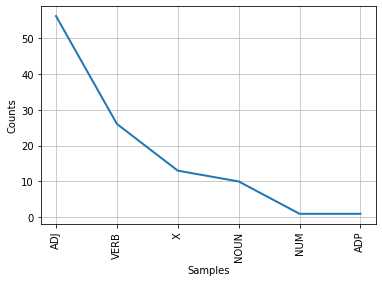

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [60]:
# Checking distribution of unknown words POS tags

FreqDist([x[1] for x in unknown_words_pos2]).plot()

In [64]:
print([x for x in unknown_words_pos2 if x[1] =='ADJ'])

print(' ')

print(len([x for x in unknown_words_pos2 if x[1] =='ADJ']))

[('eight-count', 'ADJ', 'NOUN'), ('metropolitan', 'ADJ', 'NOUN'), ('journalistic', 'ADJ', 'NOUN'), ('large-scale', 'ADJ', 'NOUN'), ('facial', 'ADJ', 'NOUN'), ('double', 'ADJ', 'NOUN'), ('classical', 'ADJ', 'NOUN'), ('exciting', 'ADJ', 'VERB'), ('eclectic', 'ADJ', 'NOUN'), ('negotiable', 'ADJ', 'NOUN'), ('land-idling', 'ADJ', 'VERB'), ('price-depressing', 'ADJ', 'VERB'), ('labor-backed', 'ADJ', 'VERB'), ('unofficial', 'ADJ', 'NOUN'), ('packed', 'ADJ', 'VERB'), ('pre-approved', 'ADJ', 'VERB'), ('finest', 'ADJ', 'NOUN'), ('genuine', 'ADJ', 'NOUN'), ('touchy', 'ADJ', 'NOUN'), ('one-house', 'ADJ', 'NOUN'), ('bicameral', 'ADJ', 'NOUN'), ('unwashed', 'ADJ', 'VERB'), ('flatulent', 'ADJ', 'NOUN'), ('whimsical', 'ADJ', 'NOUN'), ('enviable', 'ADJ', 'NOUN'), ('inauspicious', 'ADJ', 'NOUN'), ('generous', 'ADJ', 'NOUN'), ('low-tech', 'ADJ', 'NOUN'), ('strategic', 'ADJ', 'NOUN'), ('proof', 'ADJ', 'NOUN'), ('high-volume', 'ADJ', 'NOUN'), ('awful', 'ADJ', 'NOUN'), ('would-be', 'ADJ', 'NOUN'), ('year-lo

Here, we don't see any further possible rules for 'ADJ' words. Hence, we would finalize `Viter2` as model for POS tagging.

#### Testing on new sentences

In [75]:
# input sentence

sent = 'Hurray!!! This is summer time. Let us have fun!'

In [69]:
# Dependancy

from nltk import word_tokenize

In [76]:
# tokenize sentence

sent_tokens = word_tokenize(sent)
sent_tokens

['Hurray',
 '!',
 '!',
 '!',
 'This',
 'is',
 'summer',
 'time',
 '.',
 'Let',
 'us',
 'have',
 'fun',
 '!']

In [81]:
Viter2(sent_tokens)

unknown trigger!
0 Hurray NOUN
1 ! .
2 ! .
3 ! .
4 This DET
5 is VERB
6 summer NOUN
7 time NOUN
8 . .
unknown trigger!
9 Let NOUN
10 us PRON
11 have VERB
unknown trigger!
12 fun NOUN
13 ! .


[('Hurray', 'NOUN'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('This', 'DET'),
 ('is', 'VERB'),
 ('summer', 'NOUN'),
 ('time', 'NOUN'),
 ('.', '.'),
 ('Let', 'NOUN'),
 ('us', 'PRON'),
 ('have', 'VERB'),
 ('fun', 'NOUN'),
 ('!', '.')]

## Conclusion

- Viterbi is a powerful algorithm for POS tagging. It is time consuming but gives accurate results.
- Viterbi can be further improved using algorithms like Regex tagger.

---------------------